# evaluate ekman pumping in easterlies experiment .. as a function of outcropping density class

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44677 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 200.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt= control #'01deg_jra55v13_ryf9091_easterlies_up10'
ekfi='ek_control_tmp_2150-2164.nc' #'ek_up_tmp_2150-2164d_dx_tauyf.nc'
ekfo='ekmanpump_control_sigma0'

In [5]:
variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

(2700, 3600)


In [6]:
# 15years of simulation:
start_time='2155-01-01'
end_time='2159-12-31'

#start_time='2150-01-01'
#end_time='2150-12-31'
#end_time='2164-12-31'
#end_time='2156-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-60.0) #-50.04-

##### NOTE: I was having memory troubles running this all in one go, so I've split into two sections. 
# The script needs to be run twice for the two longitude ranges, and each time change the name of the file it is saved to.

#region = 'east'
region = 'west'
if region == 'west':
    # Just cover Mertz and Ross, save as west:
    lon_slice  = slice(-280, -100)
elif region == 'east':
    # Just cover Weddell and Prydz, save as east:
    lon_slice  = slice(-100, 80)
    
#do global
lon_slice  = slice(-280, 80)

In [7]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [8]:
# Surface density:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest') #.resample({'time':'Y'}).mean('time')
pot_rho_0

,Array,Chunk
Bytes,403.75 MiB,468.75 kiB
Shape,"(60, 490, 3600)","(1, 300, 400)"
Count,234840 Tasks,1080 Chunks
Type,float32,numpy.ndarray


In [9]:
isopycnal_bins = np.arange(24., 29.1, 0.2)
isopycnal_bins

array([24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8, 26. ,
       26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8, 28. , 28.2,
       28.4, 28.6, 28.8, 29. ])

In [10]:
ekman=xr.open_mfdataset(ekfi).sel(time=slice(start_time,end_time)).to_array()
ekman

<xarray.DataArray 'stack-8167328cbd6652d7c2411526db04980e' (variable: 1, time: 60, yt_ocean: 490, xt_ocean: 3600)>
dask.array<stack, shape=(1, 60, 490, 3600), dtype=float64, chunksize=(1, 60, 490, 3600), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * time      (time) object 2155-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    geolat_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
  * variable  (variable) <U5 'ekman'

In [11]:
time_monthly = ekman.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+len(ekman.time)/12, 1).astype('int')
n_years = len(time_yearly)
n_days_array.values

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31])

In [12]:
#handle averaging with different numdays/month
ekman=ekman[0]*n_days_array.load()
ekman
# REMEMBER THIS PART
#sum(n_days_array.values)/365

<xarray.DataArray (time: 60, yt_ocean: 490, xt_ocean: 3600)>
dask.array<mul, shape=(60, 490, 3600), dtype=float64, chunksize=(60, 490, 3600), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * time      (time) object 2155-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    geolat_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    variable  <U5 'ekman'

In [13]:
#tmp=ekman.sum(dim='time')/sum(n_days_array)
#tmp[400,400].values

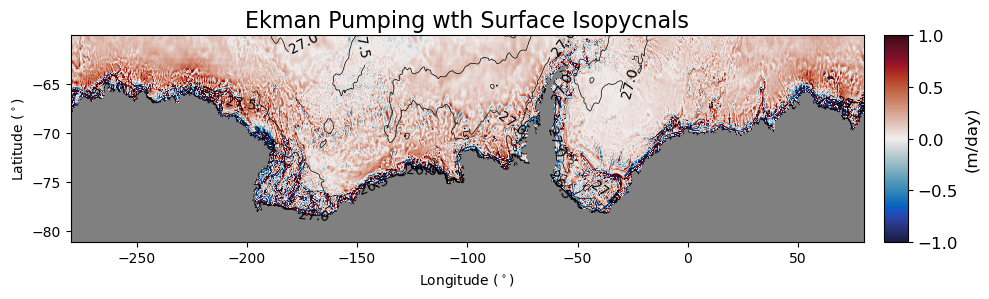

In [14]:
fontsize=12
levels=np.arange(24., 29., 0.5)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
#plt.gca().patch.set_color('.75')
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-1,vmax=1)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.title('Ekman Pumping wth Surface Isopycnals',fontsize = 16)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'(m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()


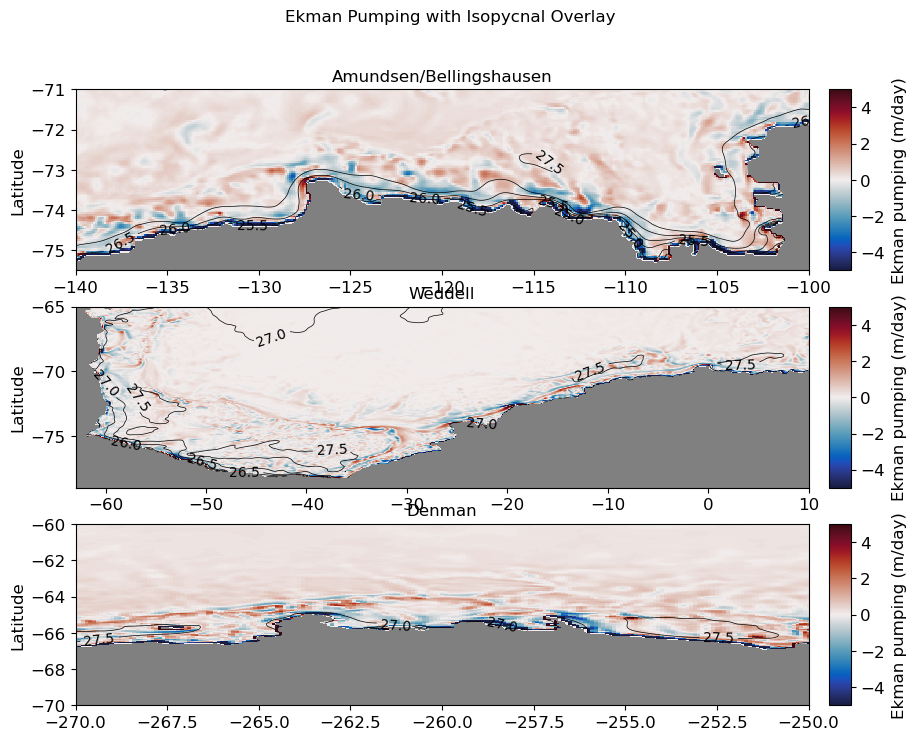

In [15]:
fontsize=12
levels=np.arange(24., 29., 0.5)

plt.figure(figsize=(10,8))
plt.suptitle('Ekman Pumping with Isopycnal Overlay')

plt.subplot(3,1,1)
#plt.gca().patch.set_color('.75')
plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
#plt.gca().patch.set_color('.5')
plt.title('Weddell',fontsize=fontsize)
plt.ylim([-79,-65])
plt.xlim([-63,10])
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')


# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
#plt.gca().patch.set_color('.5')
plt.title('Denman',fontsize=fontsize)
plt.ylim([-70,-60])
plt.xlim([-270,-250])
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')


# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)



In [16]:
for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    
    ek_tmp = ekman.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
    
    print(ek_tmp.shape,pot_rho_0_tmp.shape)
    

(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)


# Density binning sigma0:

In [18]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
#isopycnal_bins = np.arange(27.5, 28.1, 0.04)

bin_bottoms = isopycnal_bins[:-1]

binned_ekman = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(ekman.yt_ocean), len(ekman.xt_ocean))), coords = [bin_bottoms, time_yearly, ekman.yt_ocean, ekman.xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'Ekman pumping in isopycnal bins summed over time')
binned_ekman.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    
    ek_tmp = ekman.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))

    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_ekman = (ek_tmp * bin_mask).sum(dim = 'time')
        masked_ekman = masked_ekman.where(masked_ekman != 0) 
        masked_ekman = masked_ekman.load()
        binned_ekman[i,tt,:,:] = masked_ekman
        
    print('Year %i done'%time_yearly[tt])

Year 2155 done
Year 2156 done
Year 2157 done
Year 2158 done
Year 2159 done


# calculate Ekman sigma0:

In [19]:
# calculate Ekman sigma0:
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
ekman_sigma0 = binned_ekman

ekman_tmp = binned_ekman / 365. #for n_days_array

#BUG HERE??!!! numbers are off by bin_diff
ekman_sigma0 = ekman_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

# Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
#ds = xr.Dataset({'binned_salt_transformation': salt_transformation})
#ds = xr.Dataset({'binned_heat_transformation': heat_transformation})

#############################################################
#ekman_control = ekman_sigma0 
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
ekman_sigma0.coords['isopycnal_bins'] = isopycnal_bin_mid

ds = xr.Dataset({'ekman_sigma0': ekman_sigma0})
outpath = ekfo+time_period+'.nc'
ds.to_netcdf(outpath)

In [20]:
isopycnal_bin_diff

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [21]:
tmp=ekman.isel(time=slice(48, 60))
tmp

<xarray.DataArray (time: 12, yt_ocean: 490, xt_ocean: 3600)>
dask.array<getitem, shape=(12, 490, 3600), dtype=float64, chunksize=(12, 490, 3600), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * time      (time) object 2159-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    geolat_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    variable  <U5 'ekman'

In [22]:
#why off by factor of 10? ...its off by the isopycnal bin depth
tmp1=ekman_sigma0.isel(year=4).sum(dim='isopycnal_bins')
tmp2=ekman.isel(time=slice(48, 60))
tmp2=tmp2.sum(dim='time')/sum(n_days_array[0:12])
print(tmp1[400,400:410],tmp2[400,400:410].values)

<xarray.DataArray 'Ekman pumping in isopycnal bins summed over time' (xt_ocean: 10)>
array([2.38057375, 2.08824958, 1.50284086, 1.11068751, 0.96308669,
       0.70992245, 0.76424682, 1.30167684, 1.80664789, 2.20109552])
Coordinates:
    year      int64 2159
    yt_ocean  float64 -64.2
  * xt_ocean  (xt_ocean) float64 -239.9 -239.8 -239.7 ... -239.2 -239.1 -239.0 [0.47611475 0.41764992 0.30056817 0.2221375  0.19261734 0.14198449
 0.15284936 0.26033537 0.36132958 0.4402191 ]


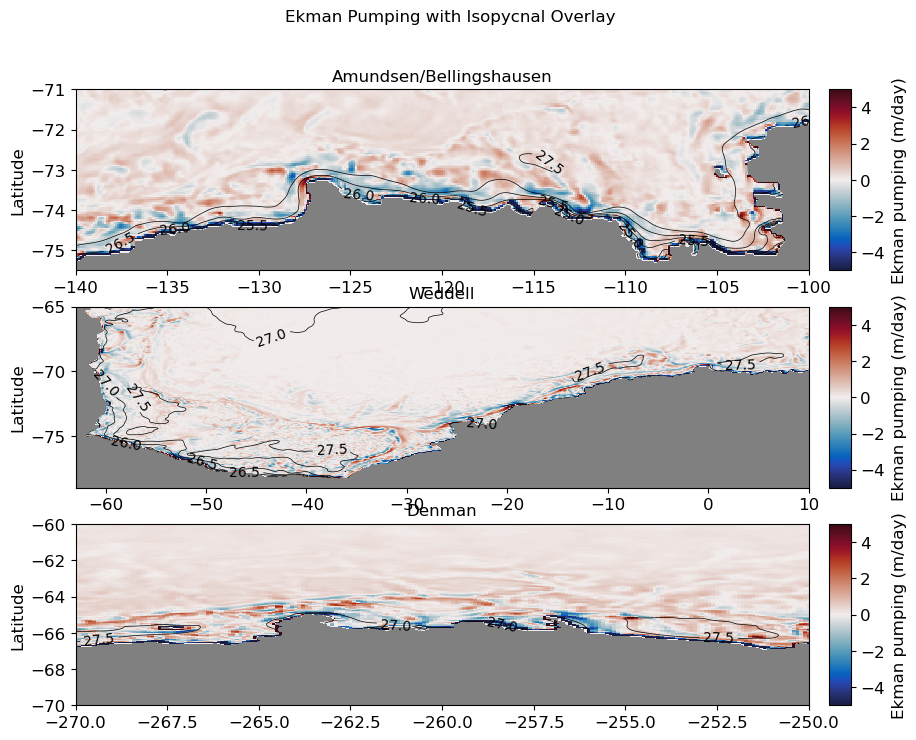

In [24]:
fontsize=12
levels=np.arange(24., 29., 0.5)

plt.figure(figsize=(10,8))
plt.suptitle('Ekman Pumping with Isopycnal Overlay')

plt.subplot(3,1,1)
#plt.gca().patch.set_color('.75')
plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
pc=plt.pcolormesh(ekman_sigma0.xt_ocean,ekman_sigma0.yt_ocean,ekman_sigma0.isel(year=0).sum(dim='isopycnal_bins')*.2,cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
#plt.gca().patch.set_color('.5')
plt.title('Weddell',fontsize=fontsize)
plt.ylim([-79,-65])
plt.xlim([-63,10])
pc=plt.pcolormesh(ekman_sigma0.xt_ocean,ekman_sigma0.yt_ocean,ekman_sigma0.isel(year=0).sum(dim='isopycnal_bins')*.2,cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')


# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
#plt.gca().patch.set_color('.5')
plt.title('Denman',fontsize=fontsize)
plt.ylim([-70,-60])
plt.xlim([-270,-250])
pc=plt.pcolormesh(ekman_sigma0.xt_ocean,ekman_sigma0.yt_ocean,ekman_sigma0.isel(year=0).sum(dim='isopycnal_bins')*.2,cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')


# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [81]:
ekman_sigma0.isel(year=0).sum(dim='isopycnal_bins')

<xarray.DataArray 'Ekman pumping in isopycnal bins summed over time' (yt_ocean: 490, xt_ocean: 3600)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.96832098, -0.93644892, -1.0037949 , ..., -1.02640242,
        -1.10357409, -1.11480984],
       [-0.91086275, -0.95828836, -1.06442125, ..., -0.8296055 ,
        -0.89375015, -0.94501763],
       [-0.9663584 , -1.04618555, -1.16054685, ..., -0.61100376,
        -0.75423631, -0.91414079]])
Coordinates:
    year      int64 2150
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95